<a href="https://colab.research.google.com/github/MedadRufus/aircraft-tracking-WSPR/blob/main/aircraft_tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mount local drive

In [188]:
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Install dependencies

In [189]:
!pip install maidenhead

# Imports

In [190]:
import pandas as pd
import maidenhead as mh
import seaborn as sns
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [191]:
headers = ["Spot_ID", "Timestamp", "Reporter", "Reporter_Grid", "SNR", "Frequency", "Call_Sign", "Grid", "Power (dBm)", "Drift (Hz/s)", "Distance (km)", "Azimuth", "Band", "Version", "Code"]
df = pd.read_csv("/content/drive/MyDrive/wsprspots-2014-03.csv.gz", names=headers, nrows = 1000000)

Convert Maidenhead locator to GPS Coordinates(WSG85)

In [192]:
def maidenhead_to_wsg85(string):
  latitude, longitude  = mh.to_location(string, center=True)
  return longitude, latitude

In [193]:
receiver_gps_coordinates = df.apply(lambda row: maidenhead_to_wsg85(row.Reporter_Grid), axis='columns', result_type='expand')
receiver_gps_coordinates.rename(columns={0:"Receiver_Longitude", 1:"Receiver_Latitude"}, inplace=True)
transmitter_gps_coordinates = df.apply(lambda row: maidenhead_to_wsg85(row.Grid), axis='columns', result_type='expand')
transmitter_gps_coordinates.rename(columns={0:"Transmitter_Longitude", 1:"Transmitter_Latitude"}, inplace=True)

In [194]:
df = pd.concat([df, receiver_gps_coordinates], axis='columns')
df = pd.concat([df, transmitter_gps_coordinates], axis='columns')

Convert Timestamp

In [195]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'],unit='s')

Now lets look at the data

In [196]:
df.sample(n=10)

,Spot_ID,Timestamp,Reporter,Reporter_Grid,SNR,Frequency,Call_Sign,Grid,Power (dBm),Drift (Hz/s),Distance (km),Azimuth,Band,Version,Code,Receiver_Longitude,Receiver_Latitude,Transmitter_Longitude,Transmitter_Latitude
12715,184577240,2014-03-01 01:32:00,N2BJW,FN34im,-14,7.040013,DC4LC,JN48np,30,0,5999,299,7,0.8_r3058,0,-73.291667,44.520833,9.125000,48.645833
845783,185210662,2014-03-04 07:58:00,VK4ZBV,QG62ml,-19,14.097076,2E0DWP,IO81rr,37,1,16640,47,14,0.8_r3058,0,153.041667,-27.520833,-2.541667,51.729167
324381,184678275,2014-03-02 09:36:00,4X1RF,KM72ls,-12,14.097077,HB9CZF,JN47ch,30,-1,2770,116,14,0.8_r3058,0,34.958333,32.770833,8.208333,47.312500
333673,184689360,2014-03-02 10:20:00,LA3JJ,JO59bh,-3,18.106131,DL1FX,JN49gr,20,0,1070,5,18,4.0 **K3-M,0,10.125000,59.312500,8.541667,49.729167
195354,184547243,2014-03-01 19:24:00,SM6/OZ6F,JO67ra,-2,14.097118,EA2COA,IN82,23,-1,1994,30,14,2.12_r3617,0,13.458333,57.020833,-3.000000,42.500000
800549,185165863,2014-03-04 03:14:00,4X1RF,KM72ls,-2,14.097092,F1IRJ,JN23wg,30,0,2784,105,14,NaN,0,34.958333,32.770833,5.875000,43.270833
903398,185269064,2014-03-04 12:26:00,HB9TJM,JN36fq,-26,28.126109,F2WA,JN38rm,37,0,217,201,28,2.11_r2263,0,6.458333,46.687500,7.458333,48.520833
530781,184890021,2014-03-03 01:10:00,KC3BWN,FM19,-12,14.097159,AA7FV,DM42pg,33,0,3118,66,14,0.8_r3058,0,-77.000000,39.500000,-110.708333,32.270833
61691,184415848,2014-03-01 08:26:00,G4NKX,IO90mt,0,14.097099,SM6/OZ6F,JO67ra,37,-1,1166,240,14,2.0_r1714,0,-0.958333,50.812500,13.458333,57.020833
416,184355017,2014-03-01 00:02:00,OH8GKP,KP24rt,-26,3.594044,OE6PWD,JN77rb,37,0,2064,13,3,2.21_r2286,0,25.458333,64.812500,15.458333,47.062500


Histogram of all parameters

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f16f9525190>,
      dtype=object)

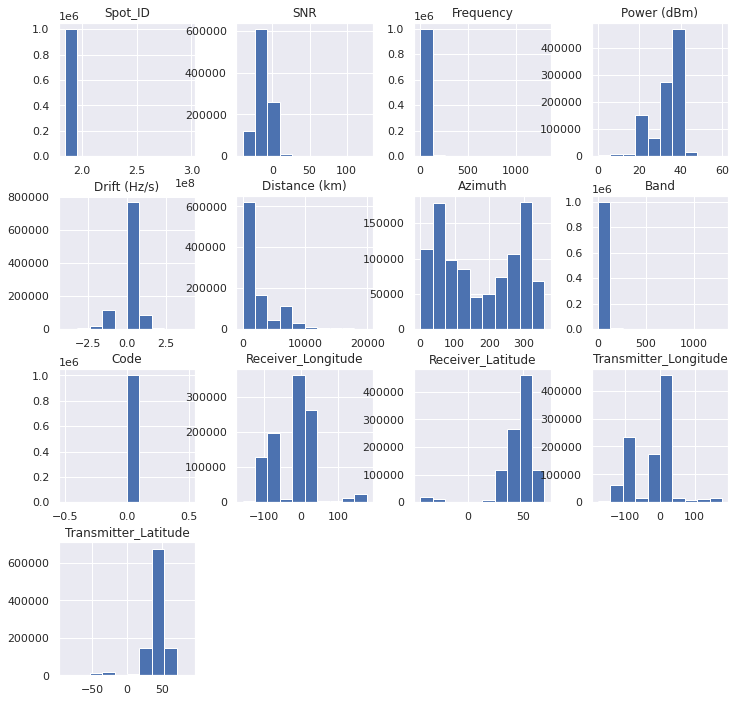

In [197]:
df.hist(figsize=(12,12))

Looks to me that the granularity of the SNR values are only 1. And the granularity of drift is 1 hz/s. I wonder how much info we can get out of it, let alone detect abnormalies. 

In [198]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 19 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   Spot_ID                1000000 non-null  int64         
 1   Timestamp              1000000 non-null  datetime64[ns]
 2   Reporter               1000000 non-null  object        
 3   Reporter_Grid          1000000 non-null  object        
 4   SNR                    1000000 non-null  int64         
 5   Frequency              1000000 non-null  float64       
 6   Call_Sign              1000000 non-null  object        
 7   Grid                   1000000 non-null  object        
 8   Power (dBm)            1000000 non-null  int64         
 9   Drift (Hz/s)           1000000 non-null  int64         
 10  Distance (km)          1000000 non-null  int64         
 11  Azimuth                1000000 non-null  int64         
 12  Band                   100000

In [199]:
df.describe()

,Spot_ID,SNR,Frequency,Power (dBm),Drift (Hz/s),Distance (km),Azimuth,Band,Code,Receiver_Longitude,Receiver_Latitude,Transmitter_Longitude,Transmitter_Latitude
count,1.000000e+06,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.0,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,1.849458e+08,-12.467126,14.615402,32.153686,-0.066674,2618.539145,171.643362,14.438663,0.0,-19.397647,44.651549,-20.148093,44.463276
std,2.186391e+06,9.502580,13.178481,6.387571,0.623491,2990.077988,112.358940,13.206827,0.0,59.122049,16.962371,56.563487,15.558434
min,1.843546e+08,-40.000000,0.001497,0.000000,-4.000000,0.000000,0.000000,-1.000000,0.0,-157.791667,-43.104167,-179.000000,-89.500000
25%,1.846087e+08,-20.000000,10.140141,30.000000,0.000000,693.000000,59.000000,10.000000,0.0,-78.041667,39.312500,-78.708333,39.645833
50%,1.848682e+08,-14.000000,14.097017,33.000000,0.000000,1320.000000,163.000000,14.000000,0.0,4.208333,49.229167,0.125000,49.062500
75%,1.851232e+08,-6.000000,14.097169,37.000000,0.000000,3279.000000,287.000000,14.000000,0.0,11.125000,52.604167,9.458333,51.812500
max,2.978685e+08,127.000000,1296.501478,60.000000,4.000000,19944.000000,360.000000,1296.000000,0.0,176.875000,69.062500,179.000000,89.500000


In [200]:
df.head()

,Spot_ID,Timestamp,Reporter,Reporter_Grid,SNR,Frequency,Call_Sign,Grid,Power (dBm),Drift (Hz/s),Distance (km),Azimuth,Band,Version,Code,Receiver_Longitude,Receiver_Latitude,Transmitter_Longitude,Transmitter_Latitude
0,184354571,2014-03-01,4X1RF,KM72ls,-17,10.140189,DC4LC,JN48np,30,0,2779,120,10,0.8_r3058,0,34.958333,32.770833,9.125,48.645833
1,184354653,2014-03-01,K9AN,EN50wc,-8,10.140189,DC4LC,JN48np,30,0,7248,303,10,NaN,0,-88.125000,40.104167,9.125,48.645833
2,184354820,2014-03-01,W3BI,FN20en,-13,10.140184,DC4LC,JN48np,30,0,6418,297,10,2.0_r1714,0,-75.625000,40.562500,9.125,48.645833
3,184354814,2014-03-01,W3HH,EL89vb,-7,10.140181,DC4LC,JN48np,30,0,7721,291,10,2.12_r3617,0,-82.208333,29.062500,9.125,48.645833
4,184354719,2014-03-01,WD4LHT,EL89tp,-17,10.140219,DC4LC,JN48np,30,0,7687,292,10,2.11_r2263,0,-82.375000,29.645833,9.125,48.645833


In [201]:
df["Call_Sign"].value_counts()

G8VDQ     39119
OZ7IT     27425
DL2XL     18785
ON7KO     15791
ON7KB     15705
          ...  
6C8QKT        1
D07HHO        1
OZ4OPN        1
OE7MBT        1
5X2WKZ        1
Name: Call_Sign, Length: 1207, dtype: int64

In [202]:
df["Reporter"].value_counts()

DK6UG       37844
OZ7IT       25394
PI4THT      25135
K9AN        23114
LA3JJ       15677
            ...  
UZ2HZ           1
G6JVT           1
KX3             1
F4GGL           1
SWL-JO00        1
Name: Reporter, Length: 1012, dtype: int64

## Now plot SNR and Drift(Hz/s) over time between a pair of transmitter/receiver station

In [210]:
TX_STATION = "G8VDQ"
RX_STATION = "OZ7IT"

In [211]:
pairs_df = df[(df["Reporter"]== RX_STATION) & (df["Call_Sign"]== TX_STATION)]
pairs_df

,Spot_ID,Timestamp,Reporter,Reporter_Grid,SNR,Frequency,Call_Sign,Grid,Power (dBm),Drift (Hz/s),Distance (km),Azimuth,Band,Version,Code,Receiver_Longitude,Receiver_Latitude,Transmitter_Longitude,Transmitter_Latitude
372,184354993,2014-03-01 00:02:00,OZ7IT,JO65df,-23,1.838053,G8VDQ,IO91um,37,0,929,59,1,2.21_r2286,0,12.291667,55.229167,-0.291667,51.520833
608,184355259,2014-03-01 00:04:00,OZ7IT,JO65df,-8,3.594049,G8VDQ,IO91um,37,0,929,59,3,2.21_r2286,0,12.291667,55.229167,-0.291667,51.520833
1242,184355813,2014-03-01 00:08:00,OZ7IT,JO65df,-25,7.040057,G8VDQ,IO91um,37,0,929,59,7,2.21_r2286,0,12.291667,55.229167,-0.291667,51.520833
1814,184356417,2014-03-01 00:12:00,OZ7IT,JO65df,-22,1.838053,G8VDQ,IO91um,37,0,929,59,1,2.21_r2286,0,12.291667,55.229167,-0.291667,51.520833
3304,184357789,2014-03-01 00:22:00,OZ7IT,JO65df,-10,1.838053,G8VDQ,IO91um,37,0,929,59,1,2.21_r2286,0,12.291667,55.229167,-0.291667,51.520833
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998446,185366433,2014-03-04 19:22:00,OZ7IT,JO65df,-13,1.838053,G8VDQ,IO91um,37,0,929,59,1,2.21_r2286,0,12.291667,55.229167,-0.291667,51.520833
998835,185366786,2014-03-04 19:24:00,OZ7IT,JO65df,-16,3.594049,G8VDQ,IO91um,37,0,929,59,3,2.21_r2286,0,12.291667,55.229167,-0.291667,51.520833
999189,185367171,2014-03-04 19:26:00,OZ7IT,JO65df,-8,14.097036,G8VDQ,IO91um,37,-1,929,59,14,2.21_r2286,0,12.291667,55.229167,-0.291667,51.520833
999190,185367111,2014-03-04 19:26:00,OZ7IT,JO65df,-12,10.140147,G8VDQ,IO91um,37,0,929,59,10,2.21_r2286,0,12.291667,55.229167,-0.291667,51.520833


In [212]:

import plotly.express as px

fig = px.line(pairs_df, x="Timestamp", y="SNR", title = f"SNR between transmit station {TX_STATION} and receive station {RX_STATION}")
fig.show()


In [213]:

import plotly.express as px

fig = px.line(pairs_df, x="Timestamp", y="Drift (Hz/s)", title = f"Drift(Hz/s) between transmit station {TX_STATION} and receive station {RX_STATION}")
fig.show()


## Now plot the locations of the transmitters and receivers

In [214]:
fig = px.line_geo(
    lon = [pairs_df['Transmitter_Longitude'].iloc[0], pairs_df['Receiver_Longitude'].iloc[0]],
    lat = [pairs_df['Transmitter_Latitude'].iloc[0], pairs_df['Receiver_Latitude'].iloc[0]],
    projection="orthographic"
)

fig.show()